## Enviroment Setup

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'utils')))

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from plotnine import *
from IPython.display import HTML
from utils.helper_funcs import *
import pickle as pkl
from fairlearn.reductions import ExponentiatedGradient

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.utils.validation") # ignore warnings about feature names

### 1 - Preprocess afib data

In [ ]:
%run utils/afib.py

### 2 - Train Models

In [ ]:
%run utils/train_models.py

Model Performance Report

In [2]:
results = []
dataset_names = ['UTI', 'AFIB', 'COMPAS']
for dataset_name in dataset_names:
# for dataset_name in ['UTI']:

    X_train, X_test, y_train, y_test = load_train_test(dataset_name, 0)
    for fair in [0,1]:        
        models = load_models(dataset_name, fair)
        for model_name, model in models.items():
            # if model_name == "Neural Network":
            #     preds_prob = model.predict_proba(X_test).squeeze().cpu().numpy()
            #     preds = model.predict(X_test).squeeze().cpu().numpy()
            # else:
            preds_prob = np.array([])
            if isinstance(model, ExponentiatedGradient):
                preds_prob = expgrad_predict_proba(model, X_test)[:, 1]
            else:
                preds_prob = model.predict_proba(X_test)[:, 1]
            preds = model.predict(X_test)

            # Compute metrics
            acc = accuracy_score(y_test, preds)
            precision = precision_score(y_test, preds)
            recall = recall_score(y_test, preds)
            f1 = f1_score(y_test, preds)
            auc = roc_auc_score(y_test, preds_prob)

            results.append({
                "Model": model_name,
                "Dataset": dataset_name,
                "fair": bool(fair),
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "ROC AUC": auc
            })


# Step 2: Convert to DataFrame
df = pd.DataFrame(results)

# Step 3: Map fair boolean to 'baseline'/'fair'
df['fair_label'] = df['fair'].map({False: 'Baseline', True: 'Fair'})

# Step 4: Melt the metrics to long format
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
df_melted = df.melt(
    id_vars=['Model', 'Dataset', 'fair_label'],
    value_vars=metrics,
    var_name='Metric',
    value_name='Value'
)

# Step 5: Pivot the table to get desired MultiIndex layout
result = df_melted.pivot_table(
    index=['Model', 'Metric'],
    columns=['Dataset', 'fair_label'],
    values='Value'
)

# Optional: Sort for readability
result = result.round(4)

# Step 6: Display
latex_table = result.to_latex(multicolumn=True, multirow=True)
result[['UTI', 'AFIB', 'COMPAS']]

Dataset                            UTI             AFIB           COMPAS  \
fair_label                    Baseline    Fair Baseline    Fair Baseline   
Model               Metric                                                 
Logistic Regression Accuracy    0.7313  0.6382   0.6844  0.6849   0.7452   
                    F1          0.5667  0.5105   0.6901  0.6915   0.7005   
                    Precision   0.6667  0.4932   0.6731  0.6727   0.7421   
                    ROC AUC     0.7816  0.7430   0.7404  0.7399   0.8244   
                    Recall      0.4928  0.5290   0.7080  0.7114   0.6634   
Neural Network      Accuracy    0.7571  0.6408   0.9923  0.9938   0.7428   
                    F1          0.6083  0.0142   0.9923  0.9938   0.6946   
                    Precision   0.7157  0.3333   0.9847  0.9877   0.7441   
                    ROC AUC     0.7724  0.6502   0.9998  1.0000   0.8208   
                    Recall      0.5290  0.0072   1.0000  1.0000   0.6514   
Random Forest       Accuracy    0.7132  0.6615   0.9886  0.9883   0.7496   
                    F1          0.6288  0.5467   0.9884  0.9881   0.7144   
                    Precision   0.5839  0.5232   1.0000  0.9999   0.7325   
                    ROC AUC     0.7859  0.7641   0.9993  0.9994   0.8239   
                    Recall      0.6812  0.5725   0.9770  0.9765   0.6973   
XGBoost             Accuracy    0.7519  0.6718   0.9896  0.9896   0.7472   
                    F1          0.5714  0.4774   0.9894  0.9894   0.6958   
                    Precision   0.7442  0.5524   0.9997  0.9997   0.7571   
                    ROC AUC     0.7887  0.7322   0.9956  0.9956   0.8241   
                    Recall      0.4638  0.4203   0.9793  0.9793   0.6437   

Dataset                                
fair_label                       Fair  
Model               Metric             
Logistic Regression Accuracy   0.7428  
                    F1         0.7023  
                    Precision  0.7314  
                    ROC AUC    0.8114  
                    Recall     0.6754  
Neural Network      Accuracy   0.6706  
                    F1         0.5936  
                    Precision  0.6658  
                    ROC AUC    0.7951  
                    Recall     0.5355  
Random Forest       Accuracy   0.7315  
                    F1         0.7006  
                    Precision  0.7018  
                    ROC AUC    0.8179  
                    Recall     0.6995  
XGBoost             Accuracy   0.7359  
                    F1         0.6974  
                    Precision  0.7184  
                    ROC AUC    0.8178  
                    Recall     0.6776

### 3 - SHAP Computation

In [4]:
results = evaluate_models(['UTI', 'AFIB', 'COMPAS'])

Calculating SHAP values for UTI...
Processing model: Logistic Regression


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/39 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/39 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/39 [00:00<?, ?it/s]

Completed: Neural Network
Processing model: Logistic Regression


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


/home/ander428/miniconda3/envs/shap/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (69) found smaller than n_clusters (100). Possibly due to duplicate points in X.


  0%|          | 0/387 [00:00<?, ?it/s]

Completed: Neural Network
Calculating SHAP values for AFIB...
Processing model: Logistic Regression


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


  0%|          | 0/1596 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


  0%|          | 0/1596 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


  0%|          | 0/1596 [00:00<?, ?it/s]

Completed: Neural Network
Processing model: Logistic Regression


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


  0%|          | 0/15959 [00:00<?, ?it/s]

Completed: Neural Network
Calculating SHAP values for COMPAS...
Processing model: Logistic Regression


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


  0%|          | 0/204 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


  0%|          | 0/204 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


  0%|          | 0/204 [00:00<?, ?it/s]

Completed: Neural Network
Processing model: Logistic Regression


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: Logistic Regression
Processing model: Random Forest


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: Random Forest
Processing model: XGBoost


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: XGBoost
Processing model: Neural Network


  0%|          | 0/2037 [00:00<?, ?it/s]

Completed: Neural Network


In [13]:
with open('output/results_test.pkl', 'wb') as f:
    pkl.dump(results, f)


In [3]:
with open('output/results_test.pkl', 'rb') as f:
    results = pkl.load(f)

## Results

### Fairness of Models

array(['UTI', 'AFIB', 'COMPAS'], dtype=object)

0.5362177929022849
0.4009052256206282
0.076746609300684
   Dataset   Fairness                Model       EOD
0      UTI   Baseline  Logistic Regression  0.293632
1      UTI   Baseline        Random Forest  0.374332
2      UTI   Baseline              XGBoost  0.461838
3      UTI   Baseline       Neural Network  0.536218
4      UTI  Mitigated  Logistic Regression  0.080467
5      UTI  Mitigated        Random Forest  0.150219
6      UTI  Mitigated              XGBoost  0.044533
7      UTI  Mitigated       Neural Network  0.033058
8     AFIB   Baseline  Logistic Regression  0.076747
9     AFIB   Baseline        Random Forest  0.001993
10    AFIB   Baseline              XGBoost  0.004004
11    AFIB   Baseline       Neural Network  0.040432
12    AFIB  Mitigated  Logistic Regression  0.051673
13    AFIB  Mitigated        Random Forest  0.002124
14    AFIB  Mitigated              XGBoost  0.004004
15    AFIB  Mitigated       Neural Network  0.009756
16  COMPAS   Baseline  Logistic Regression 

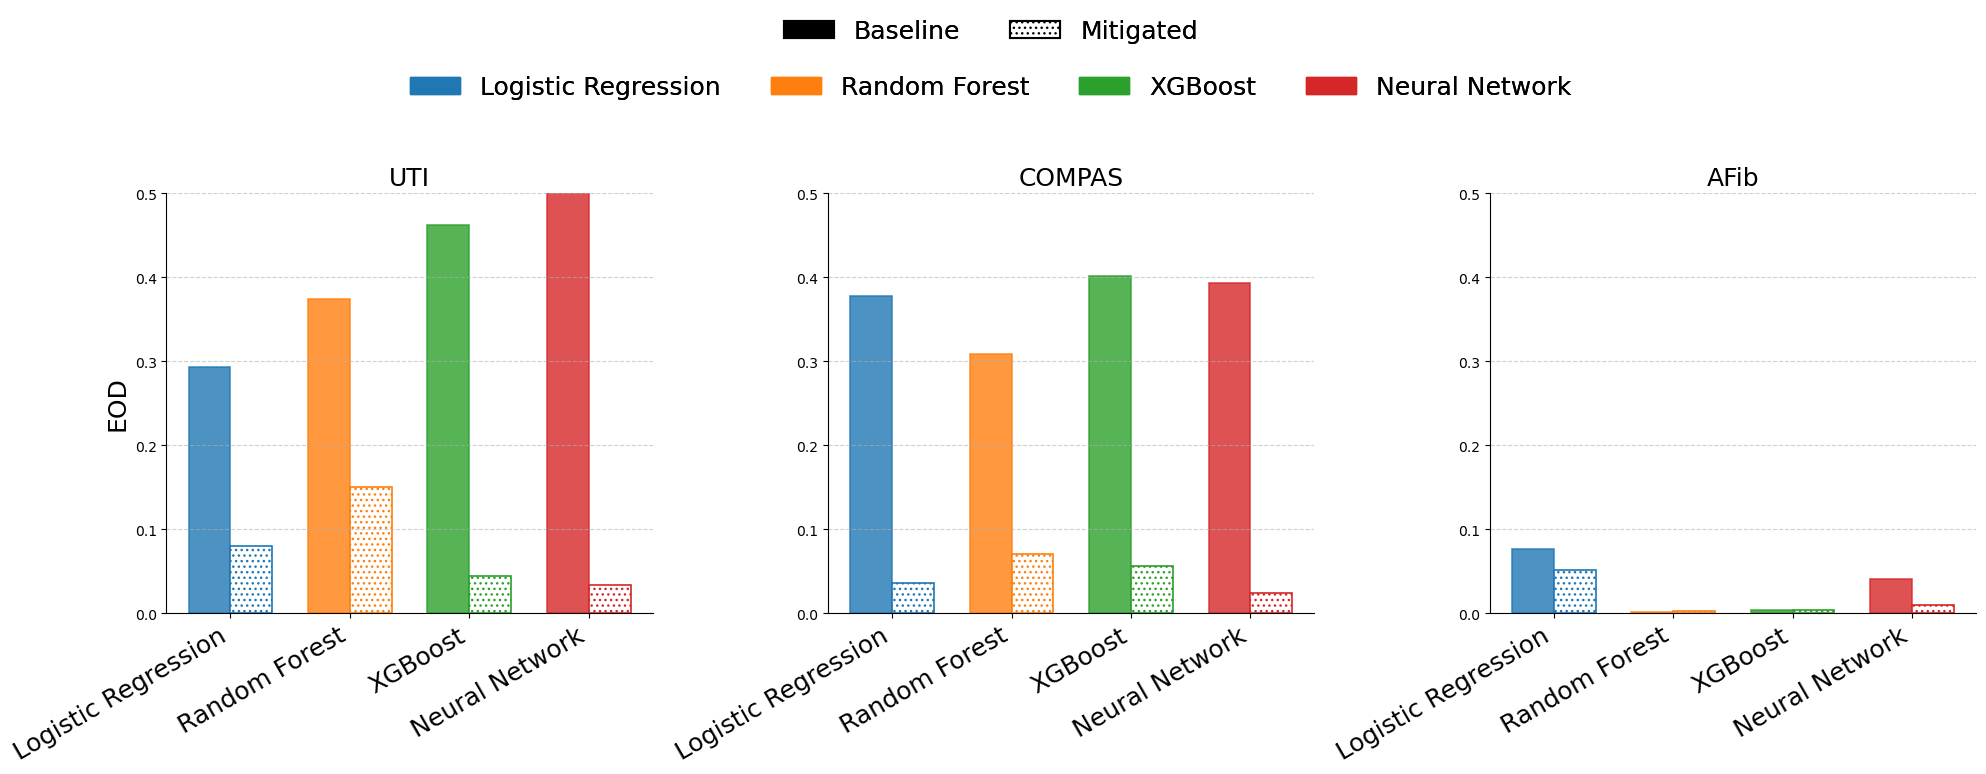

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

fontsize = 18

# Sample df creation for demonstration (replace this with your actual df)
rows = []

for dataset in results.keys():
    for fairness_type in results[dataset]['EOD'].keys():
        for i, model in enumerate(results['UTI']['shap_values'][0].keys()):
            rows.append({
                'Dataset': dataset,
                'Fairness': fairness_type,
                'Model': model,
                'EOD': results[dataset]['EOD'][fairness_type][i]
            })

df = pd.DataFrame(rows)

datasets = np.array(['UTI', 'COMPAS', 'AFIB'])
models = df['Model'].unique()


# Assign colors to models for consistency
model_colors = {
    'Logistic Regression': '#1f77b4',
    'Random Forest': '#ff7f0e',
    'XGBoost': '#2ca02c',
    'Neural Network': '#d62728'
}

hatch_pattern = '...'

fig, axs = plt.subplots(1, len(datasets), figsize=(20, 7), sharey=False)

for i, dataset in enumerate(datasets):
    ax = axs[i]
    df_ds = df[df['Dataset'] == dataset]
    
    x = np.arange(len(models))
    
    baseline_vals = [df_ds[(df_ds['Model'] == m) & (df_ds['Fairness'] == 'Baseline')]['EOD'].values[0] for m in models]
    mitigated_vals = [df_ds[(df_ds['Model'] == m) & (df_ds['Fairness'] == 'Mitigated')]['EOD'].values[0] for m in models]

    bar_width = 0.35  # width of individual bars
    x = np.arange(len(models))  # base x locations for models
    
    # Plot baseline bars slightly to the left
    bars1 = ax.bar(
        x - bar_width / 2,
        baseline_vals,
        width=bar_width,
        color=[model_colors[m] for m in models],
        edgecolor=[model_colors[m] for m in models],
        label='Baseline',
        alpha=0.8,
        linewidth=1.2
    )

    # Plot mitigated bars slightly to the right
    bars2 = ax.bar(
        x + bar_width / 2,
        mitigated_vals,
        width=bar_width,
        color='white',
        edgecolor=[model_colors[m] for m in models],
        hatch='...',
        label='Mitigated',
        linewidth=1.2
    )
    
    # abbr change
    if dataset == "AFIB":
        dataset = "AFib"

    ax.set_title(dataset, fontsize=fontsize)
    ax.set_xticks(x)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title(dataset, fontsize=fontsize)
    ax.set_xticklabels(models, rotation=30, ha='right', fontsize=fontsize)
    # ax.set_ylim(0, max(baseline_vals + mitigated_vals) * 1.1)  # 10% headroom
    ax.set_ylim(0, 0.5)  # same height

    print(max(baseline_vals + mitigated_vals))

    if i == 0:
        ax.set_ylabel('EOD', fontsize=fontsize)

# Create custom legend entries

# Fairness legend (black & white)
fairness_patches = [
    Patch(facecolor='black', edgecolor='black', label='Baseline', linewidth=1.5),
    Patch(facecolor='white', edgecolor='black', hatch=hatch_pattern, label='Mitigated', linewidth=1.5)
]

# Model legend (colors only)
model_patches = [Patch(facecolor=color, edgecolor=color, label=model) for model, color in model_colors.items()]

# Draw fairness legend first, then model legend below by calling fig.legend twice

# First fairness legend — centered below the plots, few columns
leg1 = fig.legend(
    handles=fairness_patches,
    loc='lower center',
    ncol=2,
    fontsize=fontsize,
    frameon=False,
    bbox_to_anchor=(0.5, 1),
    borderaxespad=0.
)

# Second model legend — centered below the fairness legend
leg2 = fig.legend(
    handles=model_patches,
    loc='lower center',
    ncol=4,
    fontsize=fontsize,
    frameon=False,
    bbox_to_anchor=(0.5, .92),
    borderaxespad=0.
)

# Add legends manually to the figure so they show both
fig.add_artist(leg1)
fig.add_artist(leg2)

plt.tight_layout(rect=[0, 0.1, 1, 1])

fig.subplots_adjust(top=0.8, bottom=0.2)  # leave more space around for legends
plt.savefig('output/eod_results.pdf',bbox_inches='tight')  # 300 dpi for print-quality
print(df)
plt.show()

### Export plots for SHAP differences

In [84]:
pd.DataFrame(np.abs(dict_lst[0]['Logistic Regression'])).groupby(cohort).mean()

,0,1,2,3,4,5,6,7,8
race,,,,,,,,,
False,0.067881,0.246466,0.03001,0.027877,0.004124,0.004662,0.000587,0.077704,0.071437
True,0.047348,0.209090,0.02853,0.024974,0.004104,0.004640,0.000595,0.071141,0.079874


In [313]:
from scipy.stats import spearmanr

def run_spearmanr(dict_lst, cohort):
    base_dict, fair_dict = dict_lst
    test_results = {
        "rho": {"Overall": [], "Black": [], "Other": []},
        "p-value": {"Overall": [], "Black": [], "Other": []},
    }
    for model in base_dict.keys():
        base_shap, fair_shap = np.abs(base_dict[model]).mean(axis=0), np.abs(fair_dict[model]).mean(axis=0)
        base_shap_cohort, fair_shap_cohort = pd.DataFrame(np.abs(base_dict[model])).groupby(cohort).mean(), \
                                             pd.DataFrame(np.abs(fair_dict[model])).groupby(cohort).mean()

        # test_results['Overall SHAP'] = 


        rho, p_value = spearmanr(base_shap, fair_shap)
        rho_b, p_value_b = spearmanr(base_shap_cohort.iloc[0,:], fair_shap_cohort.iloc[0,:])
        rho_o, p_value_o = spearmanr(base_shap_cohort.iloc[1,:], fair_shap_cohort.iloc[1,:])
        rho_values = {'Overall': rho, 'Black': rho_b, 'Other': rho_o}
        p_values = {'Overall': p_value, 'Black': p_value_b, 'Other': p_value_o}

        for group in rho_values.keys():
            test_results['rho'][group].append(rho_values[group])
            test_results['p-value'][group].append(p_values[group])
    return test_results
   
spearman_results = {}
for dataset in dataset_names:
    dict_lst = results[dataset]['shap_values']
    cohort = results[dataset]['shap_data'][0]['race']
    spearman_results[dataset] = run_spearmanr(dict_lst, cohort.astype(int))

print(spearman_results)

{'UTI': {'rho': {'Overall': [np.float64(0.9642857142857145), np.float64(0.9285714285714288), np.float64(0.8214285714285715), np.float64(0.6071428571428572)], 'Black': [np.float64(0.8928571428571429), np.float64(0.9642857142857145), np.float64(0.8214285714285715), np.float64(0.5714285714285715)], 'Other': [np.float64(0.9642857142857145), np.float64(0.8571428571428573), np.float64(0.8928571428571429), np.float64(0.7500000000000002)]}, 'p-value': {'Overall': [np.float64(0.0004541491691941689), np.float64(0.0025194724037946874), np.float64(0.023448808345691505), np.float64(0.1482311614811614)], 'Black': [np.float64(0.006807187408935392), np.float64(0.0004541491691941689), np.float64(0.023448808345691505), np.float64(0.1802019889115274)], 'Other': [np.float64(0.0004541491691941689), np.float64(0.01369732661532562), np.float64(0.006807187408935392), np.float64(0.05218140045705776)]}}, 'AFIB': {'rho': {'Overall': [np.float64(0.9628366282230324), np.float64(0.9296829191781231), np.float64(0.95

<>:69: SyntaxWarning: invalid escape sequence '\g'
<>:69: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_1066/77582133.py:69: SyntaxWarning: invalid escape sequence '\g'


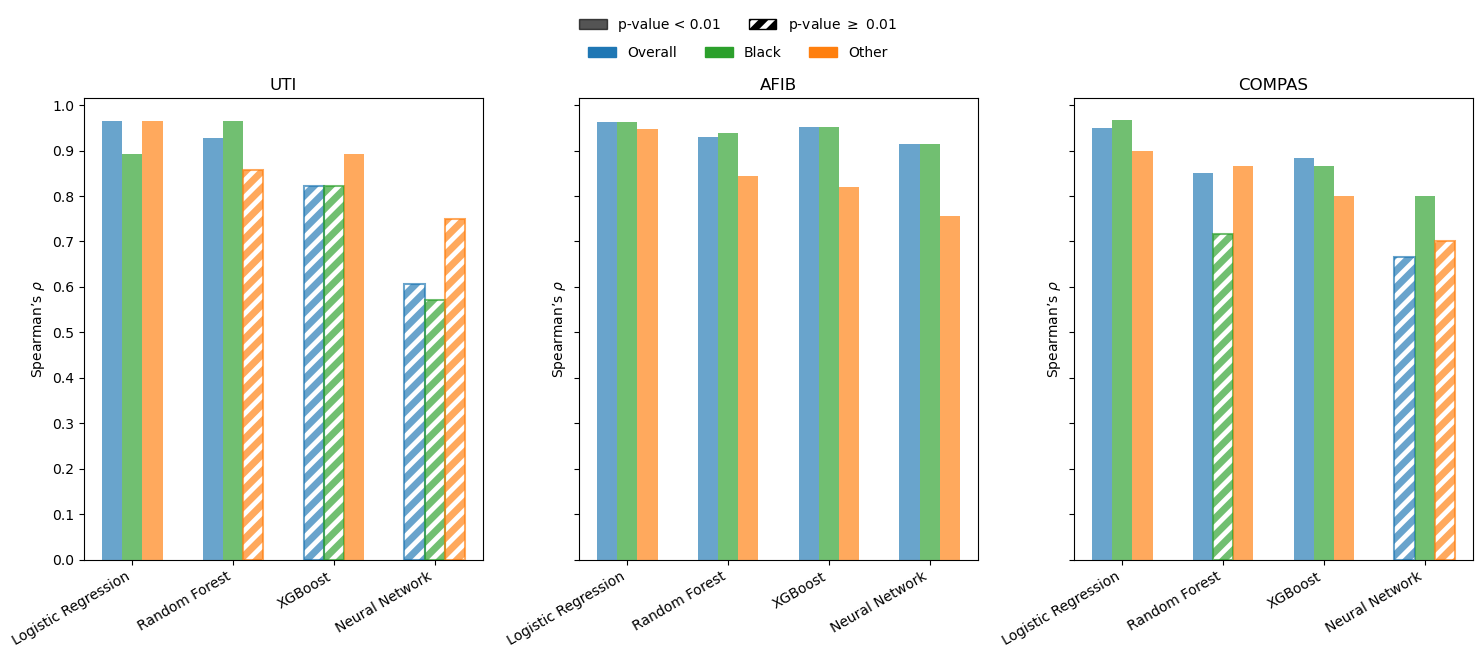

In [360]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For creating custom legend entries

# Dataset and race group names
datasets = list(spearman_results.keys())
race_groups = ['Overall', 'Black', 'Other']
race_colors = {
    "Overall": "#1f77b4",   # Blue for Overall SHAP
    "Black": "#2ca02c",     # Red for Black race group
    "Other": "#ff7f0e"      # Green for Other race group
}

    # 'Logistic Regression': '#1f77b4',
    # 'Random Forest': '#ff7f0e',
    # 'XGBoost': '#2ca02c',
    # 'Neural Network': '#d62728'

model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']

alpha = 0.67
# Create the plot with subplots (facets for each dataset)
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(15, 6), sharey=True)

# Loop through each dataset and plot rho values with p-values
for dataset_idx, dataset in enumerate(datasets):
    ax = axes[dataset_idx]  # Select the subplot axis for the current dataset
    
    # Create an array to store the position of each bar for each race group
    bar_width = 0.2  # Width of the bars
    positions = np.arange(len(model_names))  # X positions for each model
    
    for i, race_group in enumerate(race_groups):
        # Get the rho and p-value data for the dataset and race group
        rho_values = spearman_results[dataset]['rho'][race_group]
        p_values = spearman_results[dataset]['p-value'][race_group]
        
        # Adjust bar positions so they don't overlap
        offset_positions = positions + i * bar_width
        
        # Loop through each model and plot the rho value as a bar
        for model_idx, (rho, p_value) in enumerate(zip(rho_values, p_values)):
            # Color bars based on p-value significance
            if p_value < 0.01:
                # Filled bar for significant p-values
                ax.bar(offset_positions[model_idx], rho, bar_width, color=race_colors[race_group], alpha=alpha, label=race_group if model_idx == 0 else "")
            else:
                # Stripped (hatch) bar for non-significant p-values
                ax.bar(offset_positions[model_idx], rho, bar_width, edgecolor=race_colors[race_group], facecolor='none', linewidth=1.5, 
                        alpha=alpha, hatch='//', label=race_group if model_idx == 0 else "")

    # Customize each subplot
    ax.set_title(dataset)
    ax.set_ylabel("Spearman’s $\\rho$")
    ax.set_xticks(positions + bar_width)  # Adjust x-ticks to be in the center of grouped bars
    ax.set_xticklabels(model_names, rotation=30, ha='right')
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Y-ticks from 0 to 1

# Custom legend for race groups (color) using Patch
legend_color_handles = [
    Patch(color=race_colors['Overall'], label='Overall'),
    Patch(color=race_colors['Black'], label='Black'),
    Patch(color=race_colors['Other'], label='Other')
]

# Custom legend for hatch patterns (significant vs non-significant) using Patch
legend_hatch_handles = [
    Patch(edgecolor='black', facecolor='black', label='p-value < 0.01', alpha=alpha),
    Patch(edgecolor='black', facecolor='none', hatch='//', label='p-value $\geq$ 0.01'),
]

# Create the first legend (cohorts: Overall, Black, Other)
fig.legend(
    handles=legend_color_handles, 
    loc='upper center', 
    ncol=3, 
    fontsize=10, 
    bbox_to_anchor=(0.5, 1.05), 
    frameon=False,
    borderaxespad=0.5
)

# Create the second legend (hatch patterns: Filled vs. Stripped)
fig.legend(
    handles=legend_hatch_handles, 
    loc='upper center', 
    ncol=2, 
    fontsize=10, 
    bbox_to_anchor=(0.5, 1.1), 
    frameon=False,
    borderaxespad=0.5
)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [181]:
race = results['UTI']['shap_data'][0]['race'].astype(int)
results['UTI']['shap_values'][0]['Logistic Regression'][race==1].shape

(98, 7)

UTI
[np.float64(0.9), np.float64(0.8666666666666667), np.float64(0.7999999999999999), np.float64(0.7)]
UTI
[np.float64(0.9642857142857145), np.float64(0.9285714285714288), np.float64(0.8214285714285715), np.float64(0.6071428571428572)]
UTI
[np.float64(0.8928571428571429), np.float64(0.9642857142857145), np.float64(0.8214285714285715), np.float64(0.5714285714285715)]
AFIB
[np.float64(0.9642857142857145), np.float64(0.8571428571428573), np.float64(0.8928571428571429), np.float64(0.7500000000000002)]
AFIB
[np.float64(0.9628366282230324), np.float64(0.9296829191781231), np.float64(0.9514779292971367), np.float64(0.9136952528436609)]
AFIB
[np.float64(0.9634389613657359), np.float64(0.938530205561183), np.float64(0.9516069068813887), np.float64(0.9153565793779096)]
COMPAS
[np.float64(0.9474659524152177), np.float64(0.8433824357198778), np.float64(0.8203839583792095), np.float64(0.7556528190391649)]
COMPAS
[np.float64(0.9500000000000001), np.float64(0.8499999999999999), np.float64(0.883333333

/tmp/ipykernel_1066/1930813060.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_1066/1930813060.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_1066/1930813060.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_1066/1930813060.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_1066/1930813060.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_1066/1930813060.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp

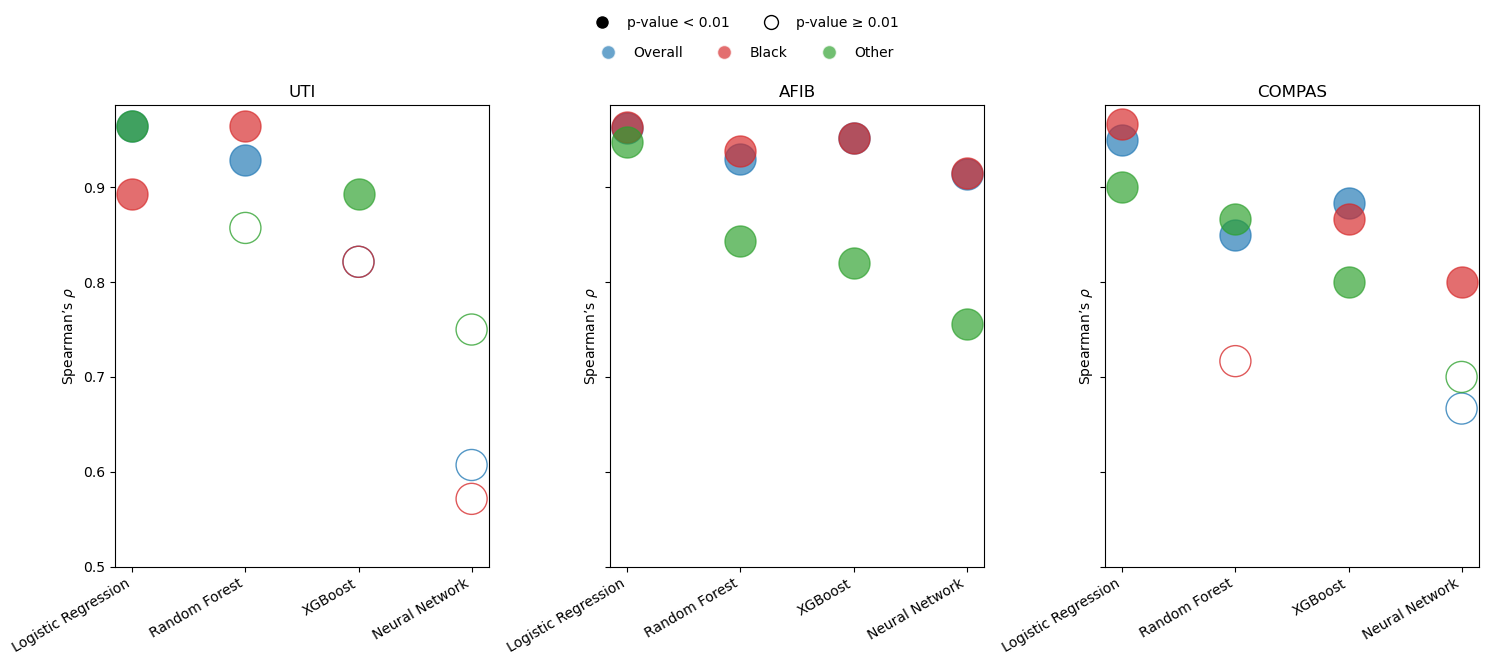

In [363]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For creating custom legend entries

# Dataset and race group names
datasets = list(spearman_results.keys())
race_groups = ['Overall', 'Black', 'Other']
race_colors = {
    "Overall": "#1f77b4",   # Blue for Overall SHAP
    "Black": "#d62728",#"#ff7f0e",   # Orange for Cohort B SHAP
    "Other": "#2ca02c"    # Green for Cohort N SHAP
}

model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']

alpha = 0.67
# Create the plot with subplots (facets for each dataset)
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(15, 6), sharey=True)

# Initialize custom legend handles for fill/outline and cohort
filled_handles = []
outlined_handles = []

# Loop through each dataset and plot rho values with p-values
for dataset_idx, dataset in enumerate(datasets):
    ax = axes[dataset_idx]  # Select the subplot axis for the current dataset
    
    for race_group in race_groups:
        # Get the rho and p-value data for the dataset and race group
        print(dataset)
        print(rho_values)
        rho_values = spearman_results[dataset]['rho'][race_group]
        p_values = spearman_results[dataset]['p-value'][race_group]
        
        # Loop through each model and plot the rho value
        for model_idx, (rho, p_value) in enumerate(zip(rho_values, p_values)):
            # Define position for the X-axis: each model has its own position
            # Determine whether to fill or outline the dot based on p-value
            if p_value < 0.01:
                # Filled dot for significant p-value
                ax.scatter(model_names[model_idx], rho, color=race_colors[race_group], s=500, alpha=alpha)
            else:
                # Outlined dot for non-significant p-value
                ax.scatter(model_names[model_idx], rho, color=race_colors[race_group], s=500, edgecolor=race_colors[race_group], facecolor='none', linewidth=1, alpha=alpha+0.1)

            ax.set_xticklabels(model_names, rotation=30, ha='right')

    # Customize each subplot
    ax.set_title(dataset)
    # ax.set_xlabel('Model Index')
    ax.set_ylabel('Spearman’s $\\rho$')
    ax.set_xticks(np.arange(4))  # 4 models, so X-ticks are [0, 1, 2, 3]
    ax.set_yticks(np.arange(0.5, 1, 0.1))  # Y-ticks from 0 to 1

legend_color_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=race_colors['Overall'], markersize=10, label='Overall', alpha=alpha),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=race_colors['Black'], markersize=10, label='Black', alpha=alpha),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=race_colors['Other'], markersize=10, label='Other', alpha=alpha)
]

# Create custom legend handles for fill/outline types
legend_fill_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='p-value < 0.01'),
    Line2D([0], [0], marker='o', color='w', markeredgewidth=1, markerfacecolor='none', markeredgecolor='black', markersize=10, label='p-value ≥ 0.01')
]

# Combine all legend handles (first cohort colors, then fill types)
legend_handles = legend_color_handles + legend_fill_handles


# Create the first legend (cohorts: Overall, Black, Other)
fig.legend(
    handles=legend_color_handles, 
    loc='upper center', 
    ncol=3, 
    fontsize=10, 
    bbox_to_anchor=(0.5, 1.05), 
    frameon=False,
    borderaxespad=0.
    )

# Create the second legend (fill types: Filled, Outlined)
fig.legend(
    handles=legend_fill_handles, 
    loc='upper center', 
    ncol=2, 
    fontsize=10, 
    bbox_to_anchor=(0.5, 1.1), 
    frameon=False,
    borderaxespad=0.
    )

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [255]:
legend_handles

In [23]:
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

mpl.rcParams['hatch.linewidth'] = 5  # increase from default 1.0
mpl.rcParams['patch.antialiased'] = True


def process_dataset_results(dataset_results, PRINT=False):
    def format_df(df, cohort):
        p_values_b, p_values_o =  df.groupby(cohort).apply(wilcoxon_across_df)

        df_formatted = df.groupby(cohort).mean()
        for col in df_formatted.columns:
            p_val_row = [p_values_b[col], p_values_o[col]]
            
            df_formatted[col] = [f"<b>{v:.4f}<br>({p_val:.4f})</b>" if p_val < 0.01 else f"{v:.4f}<br>({p_val:.4f})" for v, p_val in zip(df_formatted[col], p_val_row)]

        return df_formatted

    # call data by value not reference
    temp_data_results = deepcopy(dataset_results['shap_values'])
    temp_data = deepcopy(dataset_results['shap_data'])
    temp_data[0].loc[:,'race'] = ["Black" if int(race)==1 else "Other" for race in temp_data[0]['race']] # add labels to race variable
    # temp_data[1].loc[:,'race'] = ["Black" if int(race)==1 else "Other" for race in temp_data[1]['race']] # add labels to race variable

    index_tuples = []
    processed_results = pd.DataFrame()
    processed_results_formatted = pd.DataFrame()

    for model in list(temp_data_results[0].keys()):
        index_tuples.append((model, 'Black'))
        index_tuples.append((model, 'Other'))
        temp = pd.DataFrame(temp_data_results[1][model]-temp_data_results[0][model], columns=temp_data[0].columns.values)
        
        groupd_df = temp.groupby(temp_data[0]['race']).mean() # use base data race information over transformed data
        grouped_df_formatted = format_df(temp, temp_data[0]['race'])

        processed_results = pd.concat([processed_results, groupd_df])
        processed_results_formatted = pd.concat([processed_results_formatted, grouped_df_formatted])

    processed_index = pd.MultiIndex.from_tuples(
        index_tuples,
        names=['Model', 'Race']
    )

    processed_results.index = processed_index
    processed_results_formatted.index = processed_index

    if PRINT:
        return HTML(processed_results_formatted.to_html(escape=0))
    else:
        return processed_results, processed_results_formatted, temp_data

def plot_results_matplotlib(all_results):
    """
    all_results: dict or DataFrame-like object
        Example format:
        {
            'Dataset1': df1,  # MultiIndex ['Model','Race'] × features
            'Dataset2': df2,
            'Dataset3': df3
        }
    """
    # --- Config ---
    fontsize = 18
    hatch_pattern = '//'
    alpha_fill = 0.6
    bar_width = 0.35

    datasets = list(all_results.keys())
    nrows, ncols = len(datasets), 4  # one row per dataset, up to 4 models per row

    fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), sharey=False)
    if nrows == 1:
        axs = np.array([axs])  # make 2D for consistency

    for row_idx, dataset_name in enumerate(datasets):
        df = all_results[dataset_name]

        # --- Ensure MultiIndex ---
        if 'Model' in df.columns and 'Race' in df.columns:
            df = df.set_index(['Model', 'Race'])
        if df.index.names != ['Model', 'Race']:
            df.index.set_names(['Model', 'Race'], inplace=True)

        races = df.index.get_level_values('Race').unique()
        models = df.index.get_level_values('Model').unique()

        for i, model in enumerate(models):
            if i >= ncols:
                continue  # skip extras beyond 4 per row
            ax = axs[row_idx, i]
            df_m = df.loc[model]

            # Compute mean absolute SHAP diff per feature
            feature_importance = df_m.abs().mean(axis=0).sort_values(ascending=False)

            # Select top 5 features, skipping duplicates by base name
            top_n = 5
            selected_bases = set()
            top_features = []

            if dataset_name == "AFIB": ### manually add race to afib plot as 6th features
                top_features.append('race')
            for col in feature_importance.index:
                base = col.split('_')[0]
                if base not in selected_bases:
                    selected_bases.add(base)
                    top_features.append(col)
                    top_n -= 1
                if top_n == 0:

                    break

            df_top = df_m[top_features]
            x = np.arange(len(top_features))

            for j, race in enumerate(races):
                offset = (j - (len(races) - 1) / 2) * bar_width
                vals = df_top.loc[race].values

                for k, val in enumerate(vals):
                    color_edge = '#2ca02c' if val >= 0 else '#d62728'
                    color_fill = color_edge

                    ax.barh(
                        x[k] + offset,
                        val,
                        height=bar_width,
                        facecolor=color_fill,
                        alpha=alpha_fill,
                        edgecolor='black',
                        hatch=hatch_pattern if j != 0 else None,
                        linewidth=1.5,
                    )

            # --- Axis formatting ---
            ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  # maximum 5 ticks
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize-5)
            ax.set_yticks(x)
            if i == 0:  # only first column shows feature names
                y_labels = []
                for label in top_features:
                    # For AFIB only, add an asterisk to 'race'
                    if dataset_name == "AFIB" and label.strip().lower() == "race":
                        label = "*race"
                    if '(' in label:
                        parts = label.split('(', 1)
                        new_label = parts[0] + '\n(' + parts[1]
                        y_labels.append(new_label)
                    else:
                        y_labels.append(label)
                ax.set_yticklabels(y_labels, fontsize=fontsize)

                row_idx_map = {0: '(a)', 1: '(b)', 2: '(c)'}
                ax.set_ylabel(row_idx_map[row_idx], ha='left', va='center', rotation=0, fontsize=fontsize + 2, labelpad=60, fontweight='bold')
                ax.yaxis.set_label_position("left")
                ax.yaxis.set_label_coords(-1.25, 0.5)  # tweak horizontal offset
            elif i == 3:
                ax.set_ylabel(dataset_name, fontsize=fontsize + 2, labelpad=10)
                ax.yaxis.set_label_position("right")
            else:
                ax.set_yticklabels([])

            if row_idx == 0:
                ax.set_title(model, fontsize=fontsize + 2)
            ax.set_xlabel('')
            ax.axvline(0, color='black', linewidth=1)
            ax.grid(axis='x', linestyle='--', alpha=0.6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # Hide unused subplots in the row (if fewer than 4 models)
        for i in range(len(models), ncols):
            axs[row_idx, i].set_visible(False)

    # --- Legends ---
    green_rgba = (0.176, 0.631, 0.263, alpha_fill)
    red_rgba = (0.843, 0.157, 0.157, alpha_fill)
    race_patches = [
        Patch(facecolor='white', edgecolor='black', label=races[0], linewidth=3, alpha=1),
        Patch(facecolor='white', edgecolor='black', hatch=hatch_pattern, label=races[1], linewidth=3, alpha=1)
    ]
    sign_patches = [
        Patch(facecolor=green_rgba, edgecolor=green_rgba, label='Positive', linewidth=1.5),
        Patch(facecolor=red_rgba, edgecolor=red_rgba, label='Negative', linewidth=1.5)
    ]

    leg1 = fig.legend(
        handles=race_patches,
        loc='lower center',
        ncol=2,
        fontsize=fontsize,
        frameon=False,
        bbox_to_anchor=(0.6, 0.96),
        borderaxespad=0.
    )
    leg2 = fig.legend(
        handles=sign_patches,
        loc='lower center',
        ncol=2,
        fontsize=fontsize,
        frameon=False,
        bbox_to_anchor=(0.6, 0.93),
        borderaxespad=0.
    )
    fig.add_artist(leg1)
    fig.add_artist(leg2)

    # --- Shared X-axis label ---
    fig.text(
        0.575,
        0.04,
        r'SHAP Difference [$\phi(f_{\text{mitigated}}, x) - \phi(f_{\text{baseline}}, x)$]',
        ha='center',
        fontsize=fontsize+5
    )

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    fig.subplots_adjust(top=0.88, bottom=0.1, wspace=0.2, hspace=0.33)
    return fig, axs


<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_1050/3360746906.py:10: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_1050/3910586504.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Other', 'Black', 'Other', 'Other', 'Black', 'Black', 'Black', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Black', 'Black', 'Black', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Black', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Black', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Black', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Black', 'Other', 'Other', 'Other', 'B

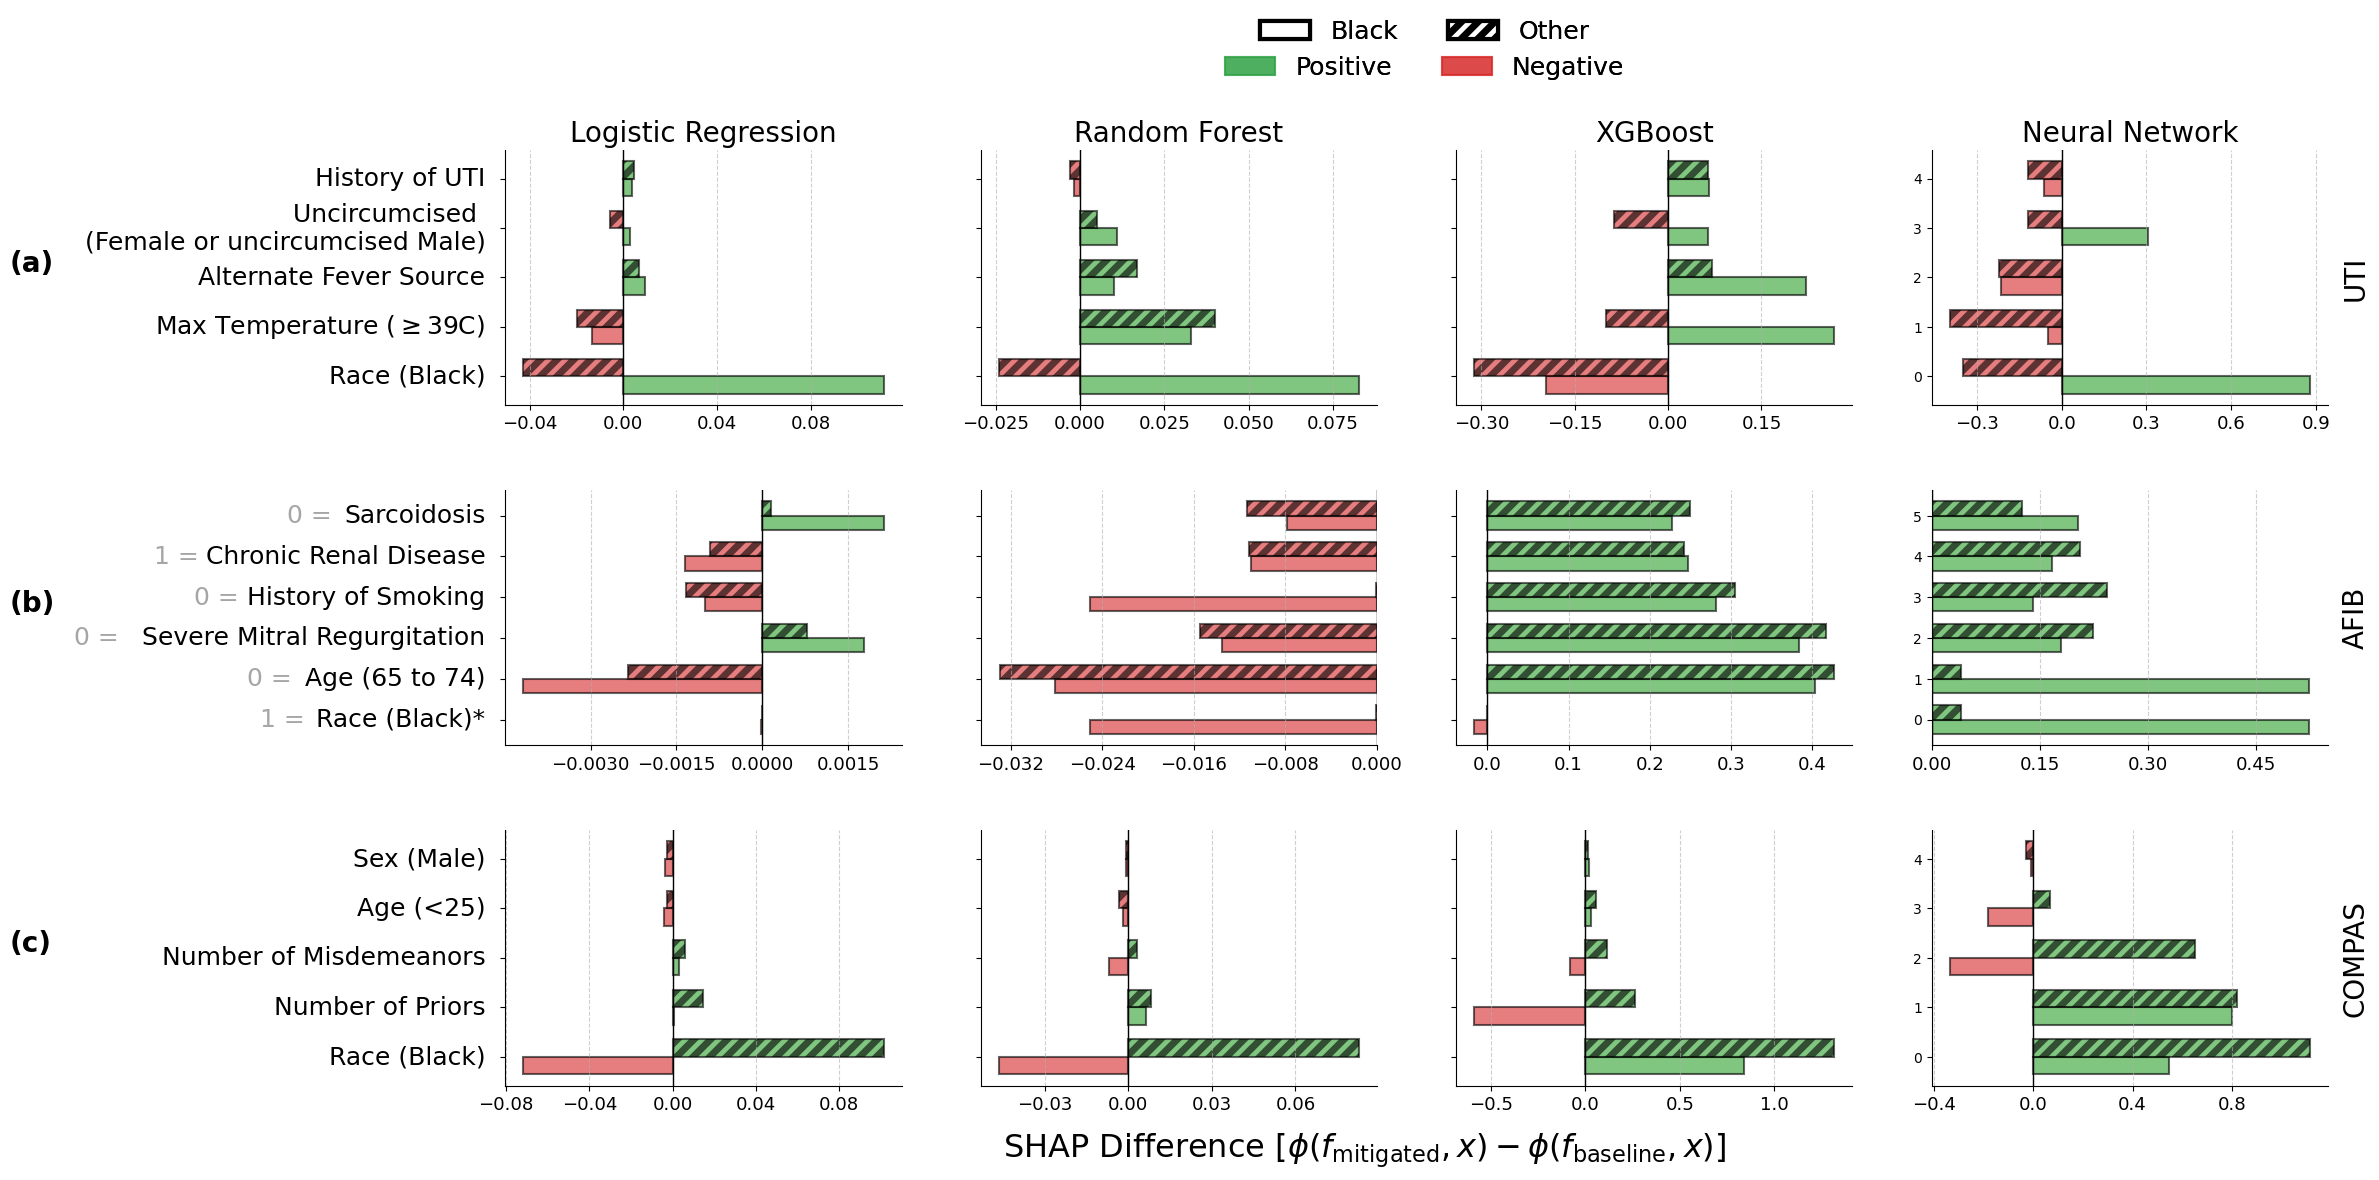

In [115]:
tables = []
plots = []
r_plot = {}
for dataset in results.keys():
    result_data, _, cohort = process_dataset_results(results[dataset], PRINT=0)
    r_plot[dataset] = result_data
    tables.append(_)
    
pretty_names = {
    'maxtempanywherege39': 'Max Temperature ($\geq$39C)', 
    'nosourceyn': 'Alternate Fever Source', 
    'race': 'Race (Black)',
    'SARCOIDOSIS_HX_0.0': '0 = Sarcoidosis',
    'CCI_RENAL_DISEASE_1.0': '1 = Chronic Renal Disease',
    'EVER_SMOKER_0.0': '0 = History of Smoking',
    'MR_SEVERE_VISIT_0.0': '0 = Severe Mitral Regurgitation',
    'AGE_65TO74_0.0': '0 = Age (65 to 74)',
    '*race': '1 = Race (Black)*',
    'sex_Male': 'Sex (Male)',
    'age_cat_Less than 25': 'Age (<25)',
    'juv_misd_count': 'Number of Misdemeanors',
    'priors_count': 'Number of Priors'
}

fig, axs = plot_results_matplotlib(r_plot)

offset = -0.05
fontsize = 18
for ax_row in axs:  # loop over rows if axs is 2D
    ax = ax_row[0]  # assuming you want the first subplot in the row
    ylabels = [t.get_text() for t in ax.get_yticklabels()]
    yticks = ax.get_yticks()
    
    # clear old labels
    ax.set_yticklabels(["" for _ in ylabels])
    
    for y, lbl in zip(yticks, ylabels):
        new_label = pretty_names.get(lbl, lbl)
        if new_label.startswith('0 =') or new_label.startswith('1 ='):
            gray_label = new_label[:4]    # "0 ="
            black_label = new_label[4:]   # rest of the label
            
            # add two overlaid text objects
            ax.text(offset - (0.0335*len(black_label)), y, gray_label, color='gray', ha='right', va='center', transform=ax.get_yaxis_transform(), fontsize=fontsize, alpha=0.7)
            ax.text(offset, y, black_label, color='black', ha='right', va='center', transform=ax.get_yaxis_transform(), fontsize=fontsize)
        else:
            # just a normal black label
            ax.text(offset, y, new_label, color='black', ha='right', va='center', transform=ax.get_yaxis_transform(), fontsize=fontsize)

fig.show()
fig.savefig(f"output/SHAP_diff.pdf", dpi=300, bbox_inches="tight")
fig.savefig(f"output/SHAP_diff.png", dpi=300, bbox_inches="tight")

In [47]:
for ax in axs:
    # for i in range(len(ax)):
    print(ax[0].get_yticklabels())

[Text(0, 0, 'race'), Text(0, 1, 'maxtempanywherege39'), Text(0, 2, 'nosourceyn'), Text(0, 3, 'Uncircumcised \n(Female or uncircumcised Male)'), Text(0, 4, 'History of UTI')]
[Text(0, 0, '*race'), Text(0, 1, 'AGE_65TO74_0.0'), Text(0, 2, 'MR_SEVERE_VISIT_0.0'), Text(0, 3, 'EVER_SMOKER_0.0'), Text(0, 4, 'CCI_RENAL_DISEASE_1.0'), Text(0, 5, 'SARCOIDOSIS_HX_0.0')]
[Text(0, 0, 'race'), Text(0, 1, 'priors_count'), Text(0, 2, 'juv_misd_count'), Text(0, 3, 'age_cat_Less than 25'), Text(0, 4, 'sex_Male')]


In [70]:
test = '0 = race'
test[4:]

'race'

In [240]:
HTML(tables[0].to_html(escape=0))

In [241]:
HTML(tables[1].to_html(escape=0))

In [242]:
HTML(tables[2].to_html(escape=0))

In [30]:
for table in tables:
    print(len(table.columns))

7
210
9


In [26]:
# Function to check if the cell contains bold HTML
def is_bold(cell):
    if isinstance(cell, str) and ('<b>' in cell.lower() or 'font-weight:bold' in cell.lower()):
        return 1
    return 0
# Collect per-dataset summaries with totals
summaries = []

for i, table in enumerate(tables):
    bold_df = table.applymap(is_bold)
    summary = bold_df.sum(axis=1).to_frame(name='count')
    summary['perc'] = summary['count'].apply(lambda x: f"{round((x / table.shape[1])*100, 2)}%")

    dataset = dataset_names[i]
    summary.columns = pd.MultiIndex.from_product([[dataset], summary.columns])

    # Add totals per model
    rows = []
    for model in summary.index.get_level_values('Model').unique():
        df_model = summary.loc[model]
        rows.append(df_model)

        # Total row per model
        # Work only with numeric counts
        total_count = df_model[(dataset, 'count')].sum()
        n_features = table.shape[1]
        total_perc = round(total_count / (2 * n_features) * 100, 2)

        total_index = pd.MultiIndex.from_tuples([(model, 'Total')], names=summary.index.names)
        total_row = pd.DataFrame([[total_count, f"{total_perc}%"]],
                                index=total_index, columns=summary.columns)
        rows.append(total_row)


    summary_with_totals = pd.concat(rows)
    summaries.append(summary_with_totals)

# Concatenate along columns
final_summary = pd.concat(summaries, axis=1)

# Suppose your DataFrame is final_summary
# Create a new MultiIndex manually
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']
races = ['Black', 'Other']

new_index = []

i = 0
for model in models:
    # Add race rows
    for race in races:
        new_index.append((model, race))
        i += 1
    # Add total row
    new_index.append((model, 'Total'))
    i += 1

# Assign MultiIndex
final_summary.index = pd.MultiIndex.from_tuples(new_index, names=['Model', 'Race'])
final_summary.columns = pd.MultiIndex.from_product(
    [['UTI', 'AFIB', 'COMPAS'],  # keep dataset names
     ['Sig. $\Delta \phi$', r'\% of Features']]  # new measure names
)
final_summary

<>:62: SyntaxWarning: invalid escape sequence '\D'
<>:62: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1049/2225198414.py:62: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1049/2225198414.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/tmp/ipykernel_1049/2225198414.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/tmp/ipykernel_1049/2225198414.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


UTI                 \
                          Sig. $\Delta \phi$ \% of Features   
Model               Race                                      
Logistic Regression Black                  4         57.14%   
                    Other                  5         71.43%   
                    Total                  9         64.29%   
Random Forest       Black                  5         71.43%   
                    Other                  7         100.0%   
                    Total                 12         85.71%   
XGBoost             Black                  4         57.14%   
                    Other                  5         71.43%   
                    Total                  9         64.29%   
Neural Network      Black                  5         71.43%   
                    Other                  6         85.71%   
                    Total                 11         78.57%   

                                        AFIB                 \
                          Sig. $\Delta \phi$ \% of Features   
Model               Race                                      
Logistic Regression Black                 31         14.76%   
                    Other                127         60.48%   
                    Total                158         37.62%   
Random Forest       Black                192         91.43%   
                    Other                200         95.24%   
                    Total                392         93.33%   
XGBoost             Black                177         84.29%   
                    Other                198         94.29%   
                    Total                375         89.29%   
Neural Network      Black                176         83.81%   
                    Other                199         94.76%   
                    Total                375         89.29%   

                                      COMPAS                 
                          Sig. $\Delta \phi$ \% of Features  
Model               Race                                     
Logistic Regression Black                  8         88.89%  
                    Other                  8         88.89%  
                    Total                 16         88.89%  
Random Forest       Black                  9         100.0%  
                    Other                  8         88.89%  
                    Total                 17         94.44%  
XGBoost             Black                  8         88.89%  
                    Other                  8         88.89%  
                    Total                 16         88.89%  
Neural Network      Black                  7         77.78%  
                    Other                  8         88.89%  
                    Total                 15         83.33%